In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [4]:
directories = ['train','test','val']
subdirectories = ['positive', 'negative']

trainset = './data/train/'
testset  = './data/test/'
valset   = './data/val/'


# Prepare the dataset

In [5]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(trainset,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( valset,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))


Found 620 images belonging to 2 classes.
Found 140 images belonging to 2 classes.


# Bulid Model - Transfer Learning 



--2023-04-19 20:35:09--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.128, 74.125.126.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   180MB/s    in 0.5s    

2023-04-19 20:35:10 (180 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [7]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


# Set inceptive v3 weight 
local_weights_file = './weights/inception_v3_weights.h5'

# initializing base model . InceptionV3 to pre_trained_model with changes
pre_trained_model  = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers,because they have been trained already.
for layer in pre_trained_model.layers:
  layer.trainable = False   


In [9]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [10]:
# Choose `mixed_7` as the last layer of the base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


**Add dense layers for classifier**

In [11]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for binary classification (cat or dog)
x = layers.Dense  (1, activation='sigmoid')(x)           

# Append the Newly dense network to the base model you customize
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                              

In [12]:
# Set the training parameters
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# Train the model

In [13]:
import tensorflow as tf

# Defining early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 2,
    verbose = 0, 
    restore_best_weights = True
)

In [14]:

EPOCHS = 20
BATCH_SIZE = 128

# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            batch_size = BATCH_SIZE,
            callbacks = [ early_stopping],
            epochs = EPOCHS,
            verbose = 2)

Epoch 1/20
31/31 - 67s - loss: 1.5357 - accuracy: 0.6629 - val_loss: 0.4776 - val_accuracy: 0.8071 - 67s/epoch - 2s/step
Epoch 2/20
31/31 - 52s - loss: 0.5199 - accuracy: 0.8081 - val_loss: 0.3884 - val_accuracy: 0.8429 - 52s/epoch - 2s/step
Epoch 3/20
31/31 - 42s - loss: 0.3044 - accuracy: 0.8806 - val_loss: 0.3721 - val_accuracy: 0.8500 - 42s/epoch - 1s/step
Epoch 4/20
31/31 - 49s - loss: 0.3454 - accuracy: 0.8500 - val_loss: 0.3510 - val_accuracy: 0.8143 - 49s/epoch - 2s/step
Epoch 5/20
31/31 - 38s - loss: 0.2799 - accuracy: 0.8855 - val_loss: 0.2289 - val_accuracy: 0.8929 - 38s/epoch - 1s/step
Epoch 6/20
31/31 - 38s - loss: 0.2435 - accuracy: 0.9081 - val_loss: 0.4189 - val_accuracy: 0.8286 - 38s/epoch - 1s/step
Epoch 7/20
31/31 - 43s - loss: 0.2687 - accuracy: 0.8968 - val_loss: 0.4320 - val_accuracy: 0.8429 - 43s/epoch - 1s/step
Epoch 8/20
31/31 - 41s - loss: 0.3154 - accuracy: 0.8726 - val_loss: 0.2377 - val_accuracy: 0.9214 - 41s/epoch - 1s/step
Epoch 9/20
31/31 - 39s - loss: 0

# Evaluate the results

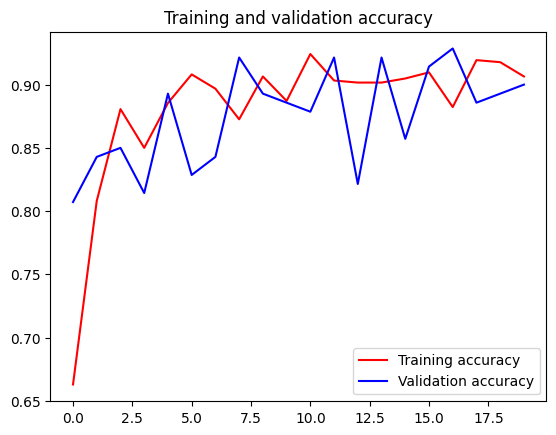

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

# Test Model

In [23]:
# Define a dictionary to convert label indices to class names
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}

# Use the trained model to predict labels for the test images
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    testset,
    target_size=(150, 150),
    batch_size=1,  # Set batch size to 1 to get individual images
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

Found 60 images belonging to 2 classes.


60/60 [==============================] - 3s 46ms/step


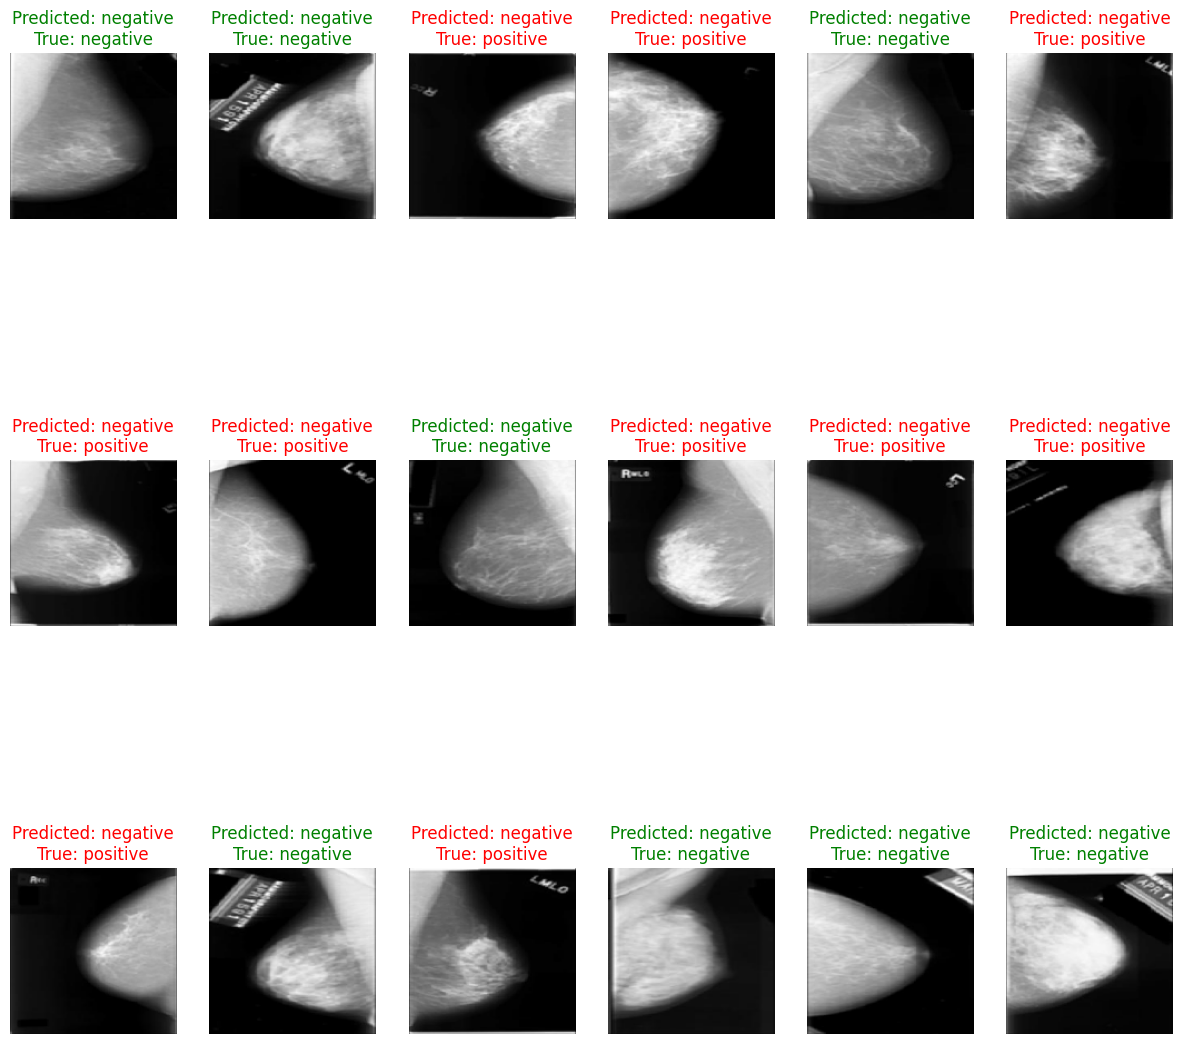

In [24]:
# Print the predicted and true labels for a subset of test images
n_rows = 3
n_cols = 6
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(150, 150))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]), 
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()